# First, activate the GPU on Colab!
- This notebook is supposed to be opened on Google Colab. 
- From the "Runtime" tab on top of the notebook, choose "Change runtime type" to select a GPU.


# SPRT-TANDEM tutorial
- Let's upload the repo onto Colab:

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # suppress warning messages

!git clone https://github.com/Akinori-F-Ebihara/SPRT-TANDEM_tutorial
os.chdir('./SPRT-TANDEM_tutorial')

## Generate the Nosaic-MNIST database
- The script ``make_nmnist.py`` will generate train and test Nosaic-MNIST databases.
- Two files, ``./data-directory/nosaic_mnist_train.tfrecords`` and ``./data-directory/nosaic_mnist_test.tfrecords`` will be generated.

In [7]:
!python make_nmnist_testonly.py

2022-06-28 01:24:10.718493: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-28 01:24:10.718589: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-28 01:24:14.868107: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-28 01:24:14.868296: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-28 01:24:14.868344: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a11db3627d0f): /proc/driver/nvidia/version does not exist
No GPU hardware devices are available, running on CPUs...
Numpy 

## Visualize example sequential data
- Choose one random test data to visualize
- The shape of one data is _(duration, width, height, channel) = (20, 28, 28, 1)_

Shape of a data in NMNIST: (20, 28, 28, 1)
Digit label:  [9]


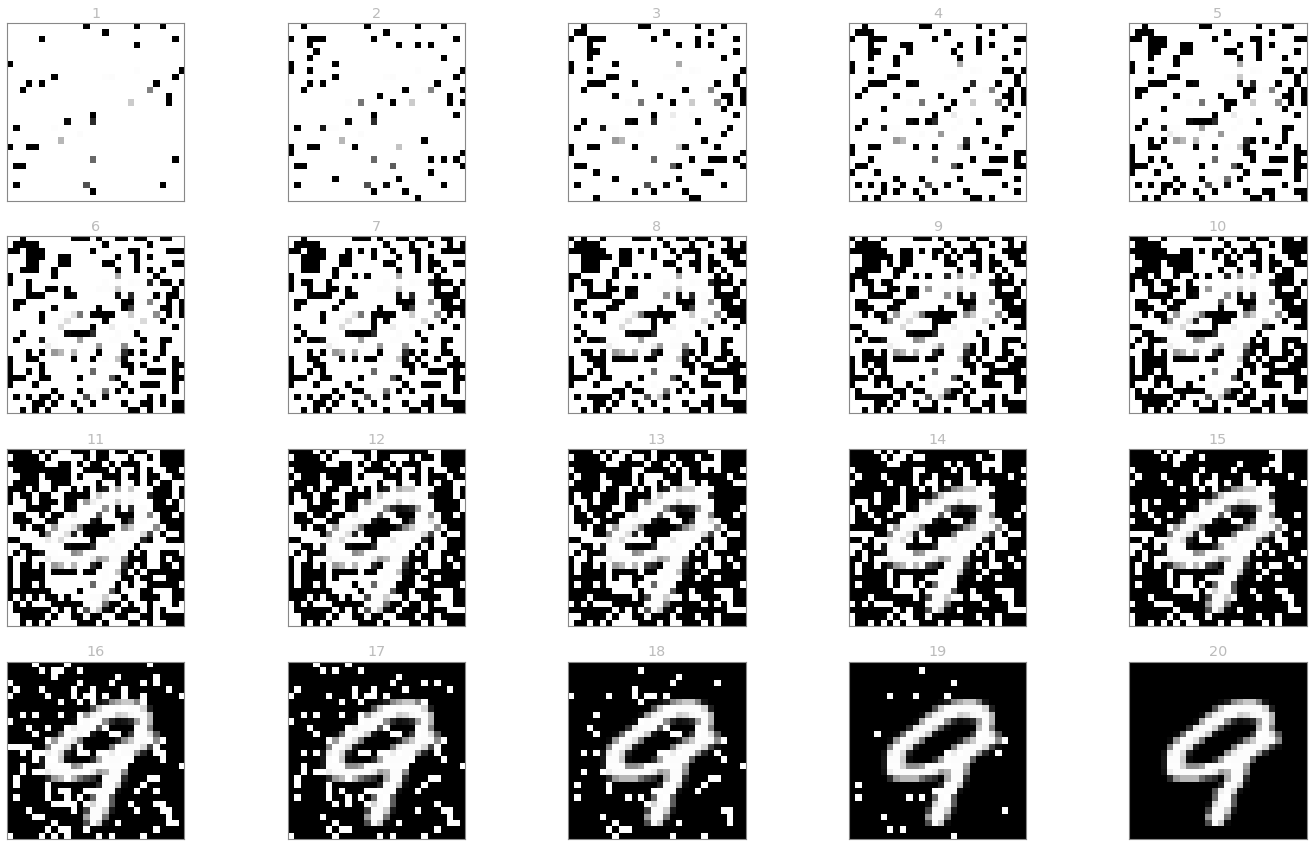

In [12]:
duration = 20 # the length of sequential data
batch_size = 100

import tensorflow as tf
from datasets.data_processing import read_tfrecords_nosaic_mnist,\
    decode_nosaic_mnist, binarize_labels_nosaic_mnist,\
    normalize_images_nosaic_mnist, reshape_for_featext

# Reed the test tfr
def _parse_image_function(example_proto):
        return tf.io.parse_single_example(example_proto, {
                    'video': tf.io.FixedLenFeature([], tf.string),
                    'label': tf.io.FixedLenFeature([],tf.int64)
                    })

record_file_test='./data-directory/nosaic_mnist_test.tfrecords'

raw_image_dataset_test = tf.data.TFRecordDataset(record_file_test)
parsed_image_dataset_test = raw_image_dataset_test.map(_parse_image_function)
parsed_image_dataset_test = parsed_image_dataset_test.batch(
    batch_size, drop_remainder=True) ###
    
for iter_b, feats in enumerate(parsed_image_dataset_test):
    x_batch, y_batch = decode_nosaic_mnist(feats, duration=duration)
    if np.random.rand() < 0.5: break

# select one data randomly from the batch
dice = np.random.permutation(batch_size)[0]
x_batch = x_batch[dice]
x_batch = tf.expand_dims(x_batch, axis=0)
y_batch = y_batch[dice]
y_batch = tf.expand_dims(y_batch, axis=0)

print('Shape of a data in NMNIST:', x_batch[0].shape)
print('Digit label: ', y_batch.numpy())

plt.figure(figsize = (24.3,15), facecolor='white')
plt.rcParams['font.size'] = 25
for i in range(duration):
  plt.subplot(4, 5, i+1)
  plt.imshow(np.squeeze(x_batch[0, i]), cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.title(i+1)
plt.show()

## Load the pretrained model
### Feature Extractor

Restored from ./data-directory/trained_models/FE_NMNIST/ckpt_step1600_mbac0.93527-6


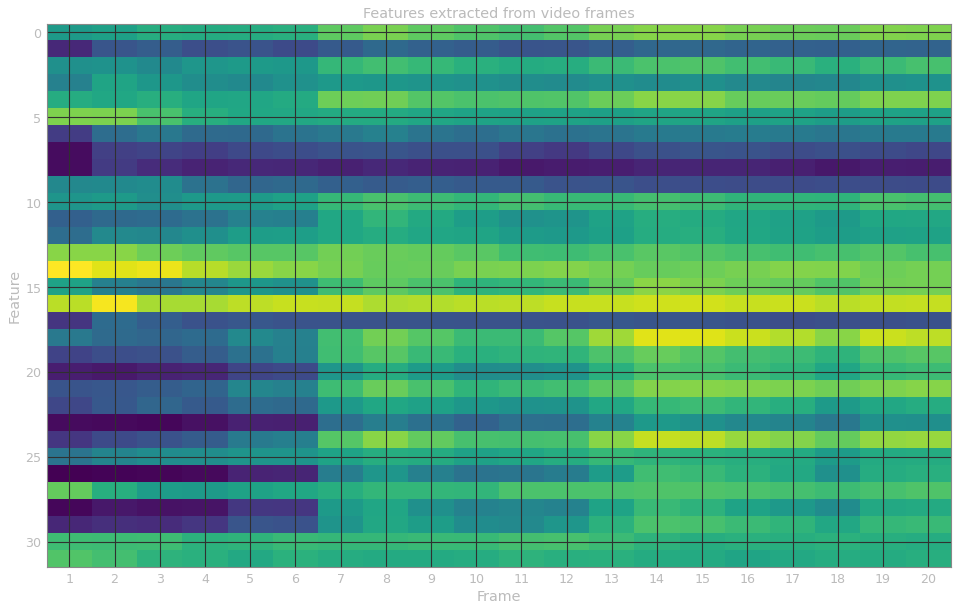

In [13]:
from models.backbones_fe import ResNetModel, get_ressize_dependent_params, checkpoint_logger_tmp
from models.backbones_ti import LSTMModelLite
from models.losses import get_loss_fe, get_gradient_lstm_ver2

root_ckptlogs = "./data-directory"
path_resume_FE =  "./data-directory/trained_models/FE_NMNIST/"
resnet_size = 44
nb_cls = 2
final_size = 32
resnet_version = 1

def load_params(model, ckpt_path):
  ckpt = tf.train.Checkpoint(net=model)

  assert os.path.exists(ckpt_path), "Not exist: path_ckpt {}".format(ckpt_path)

  # Create ckpt and manager for restore
  ckpt_manager_restore = tf.train.CheckpointManager(
      ckpt, ckpt_path, max_to_keep=3)

  # Restore the latest ckpt log.
  ckpt.restore(ckpt_manager_restore.latest_checkpoint)
  print("Restored from {}".format(ckpt_manager_restore.latest_checkpoint))        


# retrieve ResNet related parameters    
dict_resparams = get_ressize_dependent_params(resnet_version, resnet_size)

# feature extractor
model_FE = ResNetModel(
    resnet_size=resnet_size,
    bottleneck=dict_resparams["bottleneck"],
    num_classes=nb_cls,
    kernel_size=dict_resparams["kernel_size"],
    conv_stride=dict_resparams["conv_stride"],
    first_pool_size=dict_resparams["first_pool_size"],
    first_pool_stride=dict_resparams["first_pool_stride"],
    block_sizes=dict_resparams["block_sizes"],
    block_strides=dict_resparams["block_strides"],
    final_size=final_size,
    resnet_version=resnet_version,
    data_format='channels_last',
    dtype=tf.float32
)

# load the pretrained parameters
load_params(model_FE, path_resume_FE)

if nb_cls == 2:
    y_batch = binarize_labels_nosaic_mnist(y_batch)

x_batch_fe, y_batch_fe = reshape_for_featext(x_batch, y_batch, (28, 28, 1)) 
    # (bs*duration, 28,28,1), (bs*duration,)
x_batch_fe = normalize_images_nosaic_mnist(x_batch_fe)
            
# 2. Extract features
_, losses, _, feats_batch = get_loss_fe(
model_FE, 
x_batch_fe, 
y_batch_fe, 
training=False, 
param_wd=None, 
flag_wd=False,
calc_grad=False
)

ax = plt.figure(figsize=(16.2, 10), facecolor='white').gca()
plt.imshow(np.transpose(feats_batch), aspect='auto')
plt.ylabel('Feature')
plt.xlabel('Frame')
plt.title('Features extracted from video frames')
ax.set_xticks(np.arange(0, duration))
ax.set_xticklabels(np.arange(1, duration+1))
plt.rcParams.update({'font.size': 25})

# Reshape (batch, duration, final size)
feats_batch = tf.reshape(feats_batch, (1, duration, final_size)) # now batch_size=1

### Temporal integrator

In [14]:
order_sprt = 1
width_lstm = 64
path_resume_TI = "./data-directory/trained_models/TI_NMNIST/"

model_TI = LSTMModelLite(
    nb_cls, 
    width_lstm, 
    dropout=0.0, 
    activation='tanh')

# load the pretrained parameters
load_params(model_TI, path_resume_TI)

# Calc loss and grad, and backpropagation
_, losses, logits_concat, LLRs = \
                get_gradient_lstm_ver2(
    model_TI, 
    feats_batch, 
    y_batch, 
    training=True, 
    order_sprt=order_sprt,
    duration=duration,
    oblivious=False,
    version='E',
    param_multiplet_loss=1.0, 
    param_llr_loss=1.0, 
    param_wd=0.00001, 
    flag_wd=False,
    flag_mgn=False,
    calc_grad=False)

Restored from ./data-directory/trained_models/TI_NMNIST/ckpt_step2500_macrec0.94217-27


## Estimate log-likelihood ratio (LLR) and plot the LLR trajectory

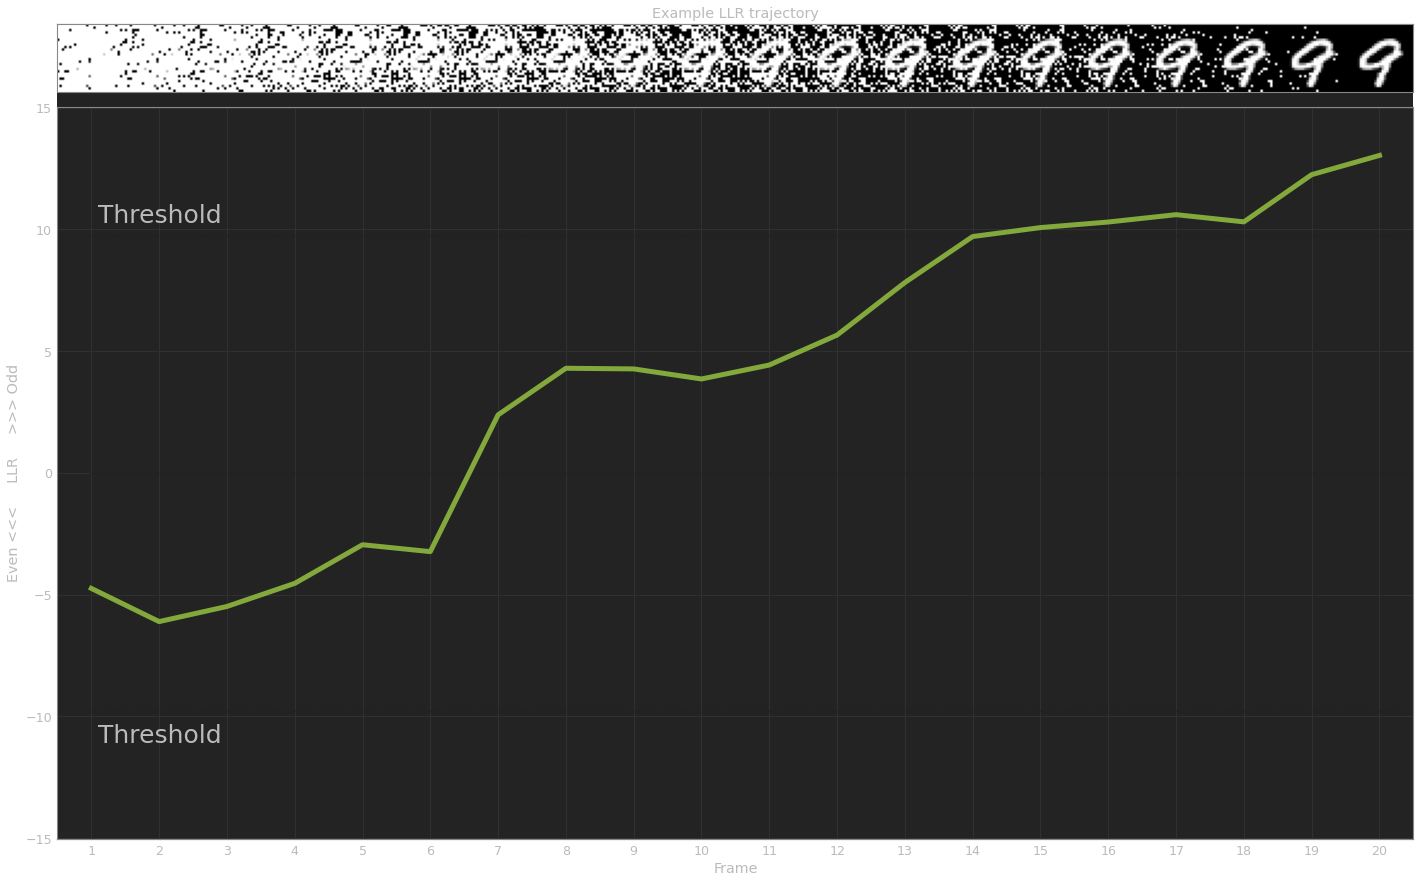

In [15]:
threshpos = 0.75

impool = []
tmp = np.squeeze(x_batch.numpy())
for i in range(duration):
  impool.append(tmp[i])

plt.rcParams['font.size'] = 25
fig = plt.figure(figsize=(24.3, 15), facecolor='white')
plt.xticks([])
plt.yticks([])
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Example LLR trajectory')

gs = fig.add_gridspec(nrows=10, ncols=1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1:, :])

ax0.set_xticks([])
ax0.set_yticks([])
ax0.imshow(np.concatenate(impool, -1), cmap='gray')

ax1.set_ylabel('Even <<<     LLR     >>> Odd')
ax1.set_xlabel('Frame')
ax1.plot([0, duration], [0, 0], 'k')
maxrange = np.max(np.abs(LLRs[:, :, 1, 0]))
ax1.plot([0, duration], [maxrange*threshpos, maxrange*threshpos], 'k--')
ax1.plot([0, duration], [-maxrange*threshpos, -maxrange*threshpos], 'k--')
ax1.text(0.1, 0.5+maxrange*threshpos, 'Threshold')
ax1.text(0.1, -0.5-maxrange*threshpos, 'Threshold', verticalalignment='top')
ax1.plot(np.transpose(LLRs[:, :, 1, 0]), linewidth=5, color='g')
ax1.set_xticks(np.arange(0, duration))
ax1.set_xticklabels(np.arange(1, duration+1))
ax1.set_xlim([-0.5, duration-0.5])
ax1.set_ylim([-maxrange-2, maxrange+2])
plt.show()



## Calculate the population average

In [16]:
LLRpool = []
labelpool = []

for iter_b, feats in enumerate(tqdm.tqdm(parsed_image_dataset_test)):
    x_batch, y_batch = decode_nosaic_mnist(feats, duration=duration)

    if nb_cls == 2:
        y_batch = binarize_labels_nosaic_mnist(y_batch)

    x_batch_fe, y_batch_fe = reshape_for_featext(x_batch, y_batch, (28, 28, 1)) 
        # (bs*duration, 28,28,1), (bs*duration,)
    x_batch_fe = normalize_images_nosaic_mnist(x_batch_fe)
                
    # 2. Extract features
    _, losses, _, feats_batch = get_loss_fe(
        model_FE, 
        x_batch_fe, 
        y_batch_fe, 
        training=False, 
        param_wd=None, 
        flag_wd=False,
        calc_grad=False
        )
    feats_batch = tf.reshape(feats_batch, (batch_size, duration, final_size))

    # Calc loss and grad, and backpropagation
    _, losses, logits_concat, LLRs = \
                    get_gradient_lstm_ver2(
        model_TI, 
        feats_batch, 
        y_batch, 
        training=True, 
        order_sprt=order_sprt,
        duration=duration,
        oblivious=False,
        version='E',
        param_multiplet_loss=1.0, 
        param_llr_loss=1.0, 
        param_wd=0.00001, 
        flag_wd=False,
        flag_mgn=False,
        calc_grad=False)
        
    LLRpool.append(LLRs)# LLRs[:, :, 1, 0]
    labelpool.append(y_batch.numpy())

LLRpool = np.concatenate(LLRpool, axis=0)
labelpool = np.concatenate(labelpool, axis=0)

100it [03:46,  2.26s/it]


## Plot the average LLR trajectories

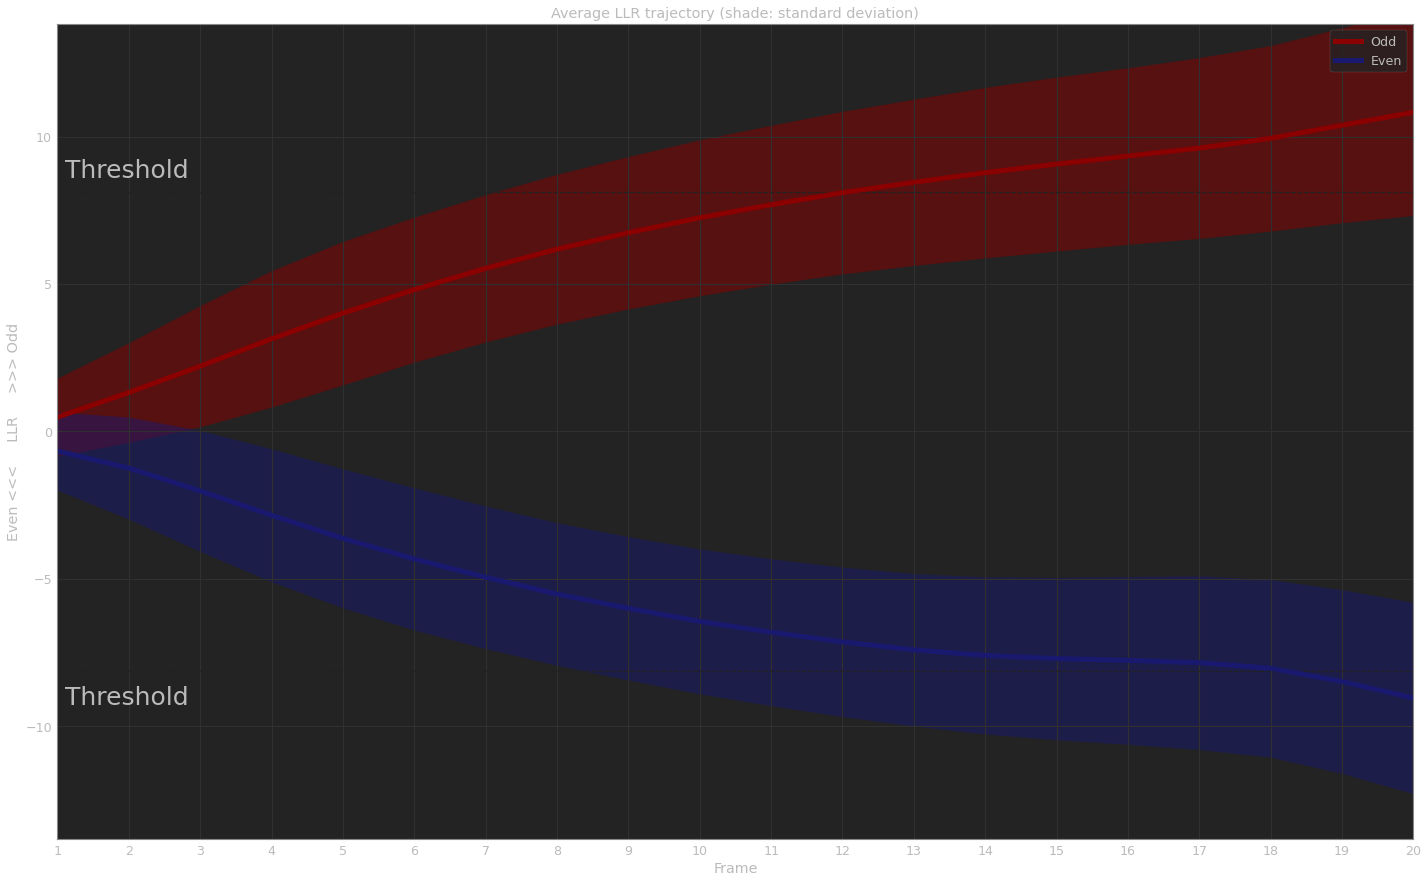

In [17]:
mean0 = np.mean(LLRpool[labelpool==0, :, 1, 0], axis=0)
std0 = np.std(LLRpool[labelpool==0, :, 1, 0], axis=0)
mean1 = np.mean(LLRpool[labelpool==1, :, 1, 0], axis=0)
std1 = np.std(LLRpool[labelpool==1, :, 1, 0], axis=0)

fig = plt.figure(figsize=(24.3, 15), facecolor='white')
maxrange = np.max([np.max(mean1), np.max(-mean0)])
minrange = np.min([np.min(mean1), np.min(-mean0)])
plt.plot([0, duration], [maxrange*threshpos, maxrange*threshpos], 'k--')
plt.plot([0, duration], [-maxrange*threshpos, -maxrange*threshpos], 'k--')
plt.text(0.1, 0.5+maxrange*threshpos, 'Threshold')
plt.text(0.1, -0.5-maxrange*threshpos, 'Threshold', verticalalignment='top')
plt.plot(mean1, color='darkred', linewidth=5, label='Odd')
plt.fill_between(np.arange(0, duration), mean1-std1, mean1+std1, color='darkred', alpha=0.5)
plt.plot(mean0, color='midnightblue', linewidth=5, label='Even')
plt.fill_between(np.arange(0, duration), mean0-std0, mean0+std0, color='midnightblue', alpha=0.5)
plt.title('Average LLR trajectory (shade: standard deviation)')
plt.ylabel('Even <<<     LLR     >>> Odd')
plt.xlabel('Frame')
plt.legend()
plt.gca().set_xticks(np.arange(0, duration))
plt.gca().set_xticklabels(np.arange(1, duration+1))
plt.xlim([0, duration-1])
plt.ylim([-maxrange-3, maxrange+3])
plt.show()

## Plot the speed-accuracy tradeoff (SAT) curve

In [18]:
from matplotlib.ticker import LogFormatter, ScalarFormatter, NullFormatter
from utils.performance_metrics import multiplet_sequential_confmx,\
    llr_sequential_confmx,\
    truncated_MSPRT, threshold_generator,\
    calc_llrs, calc_oblivious_llrs, threshold_generator, thresh_sanity_check,\
    NP_test,\
    get_LLR_min_and_max, get_linspace, threshold_generator_with_values,\
    seqconfmx_to_metrics

num_thresh = 200 # Total number of thresholds to be used to plot the SAT curve
batch_thresh = 5 # Memory consuming!! How many thresholds to be parallely computed at once. < 10 is recommended
assert num_thresh % batch_thresh == 0 # Make sure
sparsity = "linspace" # SPRT's threshold generation method."linspace" or "logspace".
class_plot = 1
dataname = 'Nosaic-MNIST'

values = get_linspace(minrange, maxrange, num_thresh, sparsity)

ls_confmx_th = []
ls_mht_th = []
ls_vht_th = []
ls_trt_th = []
for i in tqdm.tqdm(range(num_thresh // batch_thresh)):
    # Generate Thresholds for SPRT
    idx = batch_thresh * i
    itr_values = values[idx : idx + batch_thresh]
    itr_thresh = threshold_generator_with_values(itr_values, duration, nb_cls) # memory consuming
    thresh_sanity_check(itr_thresh)
    
    # Confusion matrix of SPRT, mean/var hitting time, 
    # and truncation rate
    ###########################
    tmp_confmx_th, tmp_mht_th, tmp_vht_th, tmp_trt_th = \
        truncated_MSPRT(
            llr_mtx=LLRpool,
            labels_concat=labelpool,
            thresh_mtx=itr_thresh) # Super GPU memory super-consuming if batch_thresh is large.
        # (num thresh, num classes, num classes)
        # (num thresh,)
        # (num thresh,)
        # (num thresh,)
    ls_confmx_th.append(tmp_confmx_th)
    ls_mht_th.append(tmp_mht_th)
    ls_vht_th.append(tmp_vht_th)
    ls_trt_th.append(tmp_trt_th)

confmx_th = tf.concat(ls_confmx_th, axis=0)
mht_th = tf.concat(ls_mht_th, axis=0)
vht_th = tf.concat(ls_vht_th, axis=0)
trt_th = tf.concat(ls_trt_th, axis=0)

100%|██████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.96it/s]


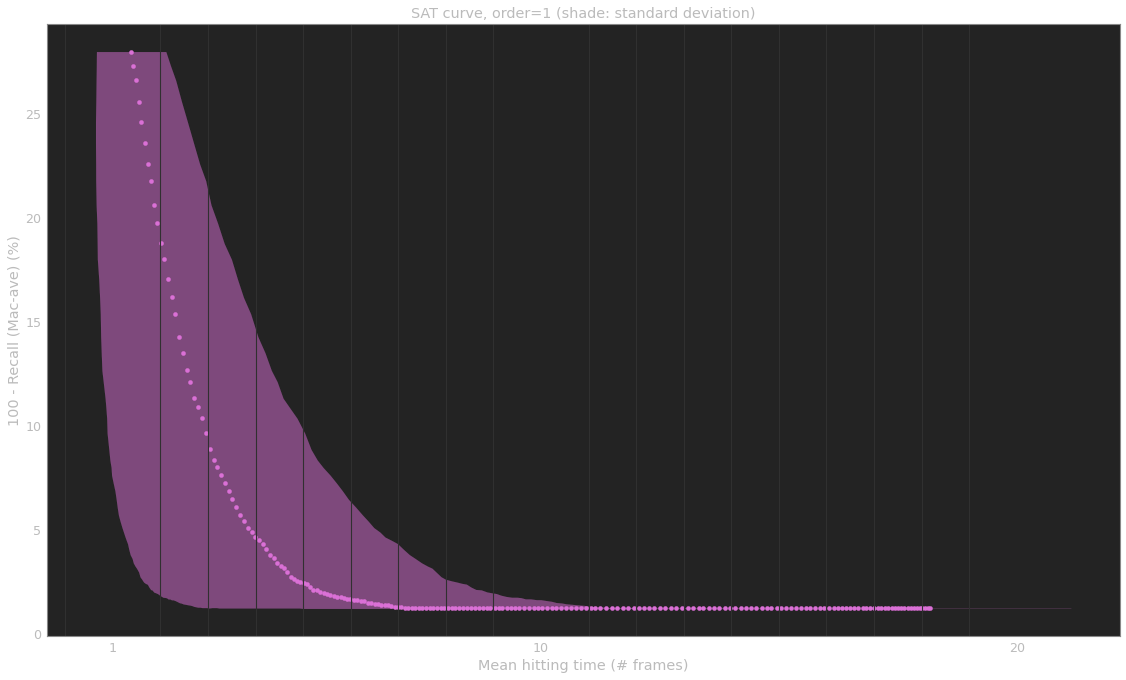

In [24]:
# Extract recalls (sensitivities)
dc_mtr = seqconfmx_to_metrics(confmx_th)

# Output
ls_sns = dc_mtr["SNS"].numpy()
    # (num thresh, num classes + 2)
    # [[recall of class 0, 1, 2, ..., recall of the last class, balanced accuracy, accuracy], ...]

ls_mht = mht_th.numpy()
    # (num thresh,)
ls_vht = vht_th.numpy()
ls_stdht = np.sqrt(ls_vht)
    # (num thresh,)
ls_trt = trt_th.numpy()
    # (num thresh,)

# Parameters
x = ls_mht
y = 100 * (1 - ls_sns[:, class_plot]) # macro-averaged recall

title = "SAT curve, order={} (shade: standard deviation)".format(order_sprt)
ylabel = '100 - Recall (Mac-ave) (%)'
xlabel = 'Mean hitting time (# frames)'


# Size
fig, ax = plt.subplots(figsize=(16.2, 10), facecolor='white')
# Scale
# ax.set_xscale('log')
# Grid
major_ticks = np.arange(0, duration + 1, 10)
major_ticks[0] += 1
minor_ticks = np.arange(0, duration + 1, 1)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(['0, 10, 20, 30, 40, 50'])
for axis in [ax.xaxis, ax.yaxis]: # ?
    axis.set_major_formatter(ScalarFormatter())
    axis.set_minor_formatter(NullFormatter())

# plot
plt.scatter(x, y, s=20, color='orchid')
plt.fill_betweenx(y, x-ls_stdht, x+ls_stdht, color='orchid', alpha=0.5)
plt.ylabel(ylabel)        
plt.xlabel(xlabel)
plt.grid(which='both')
plt.title(title)
plt.tight_layout()
plt.show()